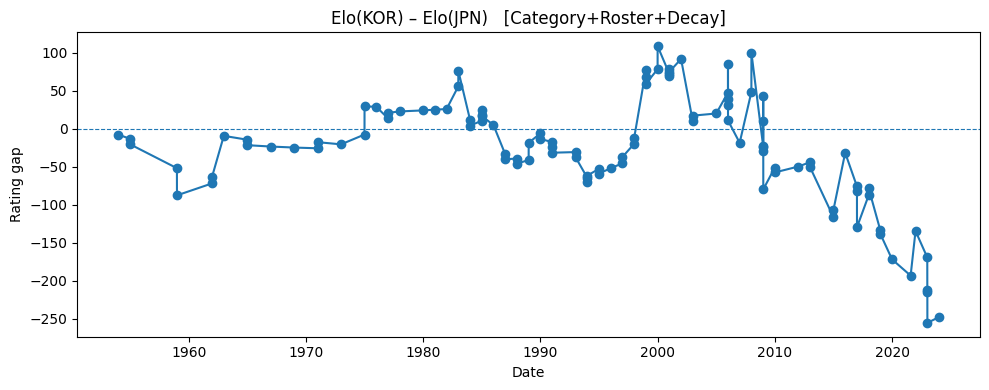

In [1]:
# ╔════════════════════════════════╗
# ║   0. 환경 준비 (필요 패키지)   ║
# ╚════════════════════════════════╝
!pip install -q openpyxl pandas matplotlib

import warnings, matplotlib.font_manager
warnings.filterwarnings("ignore", module="matplotlib.font_manager")

from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

file_path = '한일전_데이터_정리.xlsx'   # ← 업로드한 실제 위치로 수정

# ╔════════════════════════════════╗
# ║   1. 데이터 로드 & 컬럼 정리   ║
# ╚════════════════════════════════╝
df = pd.read_excel(file_path, engine='openpyxl')

# 엑셀에 오타(tournamnet) 가 있어서 바로 정정
df = df.rename(columns={'tournamnet': 'tournament'})

# 날짜 컬럼을 datetime 으로 강제 변환
df['date'] = pd.to_datetime(df['date'])

# 필수 컬럼 체크
req = ['date','team_a','team_b','winner','venue','tournament','roster_tier']
missing = [c for c in req if c not in df.columns]
if missing:
    raise ValueError(f"❌ 빠진 컬럼 있음: {missing}")

# ╔════════════════════════════════╗
# ║   2. 파라미터 (최종 버전)      ║
# ╚════════════════════════════════╝
INIT_RATING   = 1500
HOME_ADV      = 30
DECAY_BY_YEAR = 0.75

K_BY_CAT = {"A": 60, "B": 40, "C": 25, "F": 20}
ROSTER_WT = {"A": 1.00, "B": 0.65, "C": 0.30}

TOURNAMENT_CAT = {
    "WBC":          "A",
    "Olympics":     "A",
    "Premier12":    "A",
    "AsiaChamp":    "B",     # 아시아선수권
    "IntercontCup": "C",     # 대륙간컵
    "AsianGames":   "C",
    "BaseballWC":   "C",     # 야구 월드컵
    "EastAsian":    "C",
    "Friendly":     "F",
}

# ╔════════════════════════════════╗
# ║   3. Elo 계산 함수            ║
# ╚════════════════════════════════╝
def expect(r_a, r_b):
    return 1 / (1 + 10 ** ((r_b - r_a) / 400))

def update(r_a, r_b, s_a, k):
    delta = k * (s_a - expect(r_a, r_b))
    return r_a + delta, r_b - delta

def run_elo(games: pd.DataFrame):
    games = games.sort_values('date').reset_index(drop=True)
    rating = {t: INIT_RATING for t in pd.unique(games[['team_a','team_b']].values.ravel())}
    cur_year, hist = None, []

    for _, g in games.iterrows():
        # 시즌 넘어가면 Decay
        if cur_year and g.date.year != cur_year:
            rating = {t: INIT_RATING + DECAY_BY_YEAR * (r - INIT_RATING)
                      for t, r in rating.items()}
        cur_year = g.date.year

        ra, rb = rating[g.team_a], rating[g.team_b]
        if g.venue == 'home_a':   ra += HOME_ADV
        elif g.venue == 'home_b': rb += HOME_ADV

        cat    = TOURNAMENT_CAT.get(g.tournament, "F")
        k_base = K_BY_CAT[cat]
        tier   = str(g.roster_tier).upper() or cat
        k_val  = k_base * ROSTER_WT.get(tier, 1.0)

        s_a = 1 if g.winner == g.team_a else 0
        ra, rb = update(ra, rb, s_a, k_val)
        rating[g.team_a], rating[g.team_b] = ra, rb

        hist += [{"date": g.date, "team": g.team_a, "elo": ra},
                 {"date": g.date, "team": g.team_b, "elo": rb}]

    return pd.DataFrame(hist)

# ╔════════════════════════════════╗
# ║   4. 실행 & 결과 저장/시각화   ║
# ╚════════════════════════════════╝
elo_hist = run_elo(df)
elo_hist.to_csv('elo_history.csv', index=False)   # csv 다운로드 가능

# 꺾은선 그래프 (한국‑일본 Elo 차)
kor = elo_hist[elo_hist.team=='KOR'].set_index('date').elo
jpn = elo_hist[elo_hist.team=='JPN'].set_index('date').elo
gap = (kor - jpn).dropna()

plt.figure(figsize=(10,4))
plt.plot(gap.index, gap.values, marker='o')
plt.axhline(0, ls='--', lw=0.8)
plt.title('Elo(KOR) – Elo(JPN)   [Category+Roster+Decay]')
plt.ylabel('Rating gap'); plt.xlabel('Date')
plt.tight_layout(); plt.show()
